In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In the following analysis, we examine the distribution of years of birth among the customer base. 

Explanation of the output:
* The people from 1976, 1975, 1971, 1978 and 1965 are the top 5 groups of people in terms of prevalence within our data, suggesting that the marketing strategies shall be focused on these groups that form the presupposed target group.

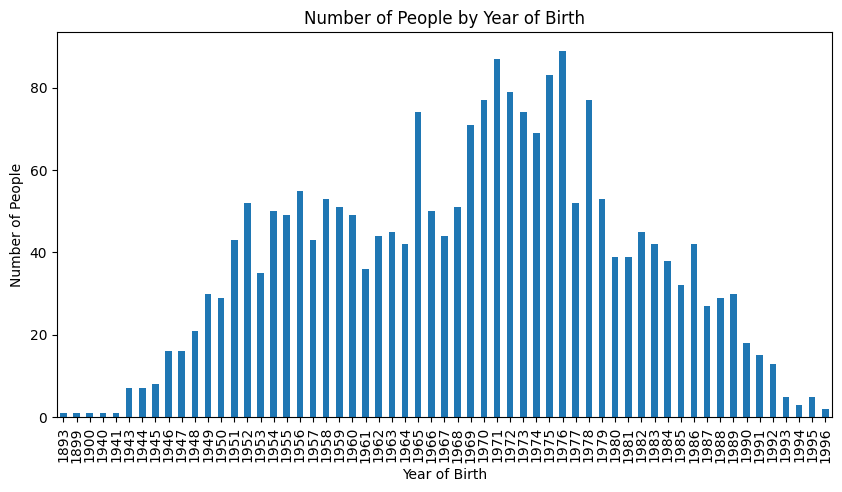

In [61]:
df = pd.read_csv('marketing_campaign.csv',delimiter=';')
birthCount = df['Year_Birth'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
birthCount.plot(kind='bar')
plt.title('Number of People by Year of Birth')
plt.xlabel('Year of Birth')
plt.ylabel('Number of People')
plt.xticks(rotation=90) 
plt.show()

In the following analysis, we examine the distribution of marital status among the customer base. 

Explanation of the output:
* Most of the people within our data are married or together. This suggests that it would be a good idea to focus on them while tailoring new campaigns.

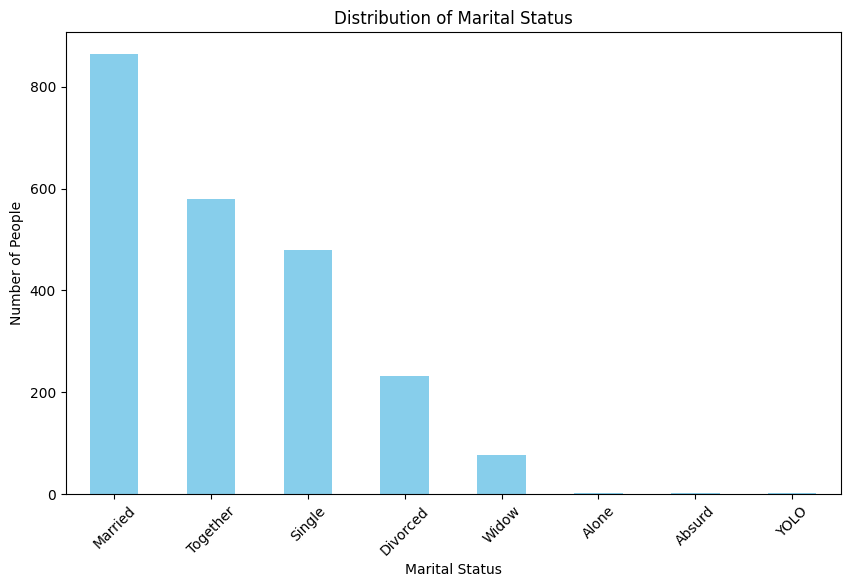

In [62]:
maritalCount = df['Marital_Status'].value_counts()

plt.figure(figsize=(10, 6))
maritalCount.plot(kind='bar', color='skyblue')
plt.title('Distribution of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of People')
plt.xticks(rotation=45)  
plt.show()

Here, we examine the distribution of education among the customer base. 

Explanation of the output:
* The prevaleting people of our customer base are the graduated ones and the one who have a PhD.

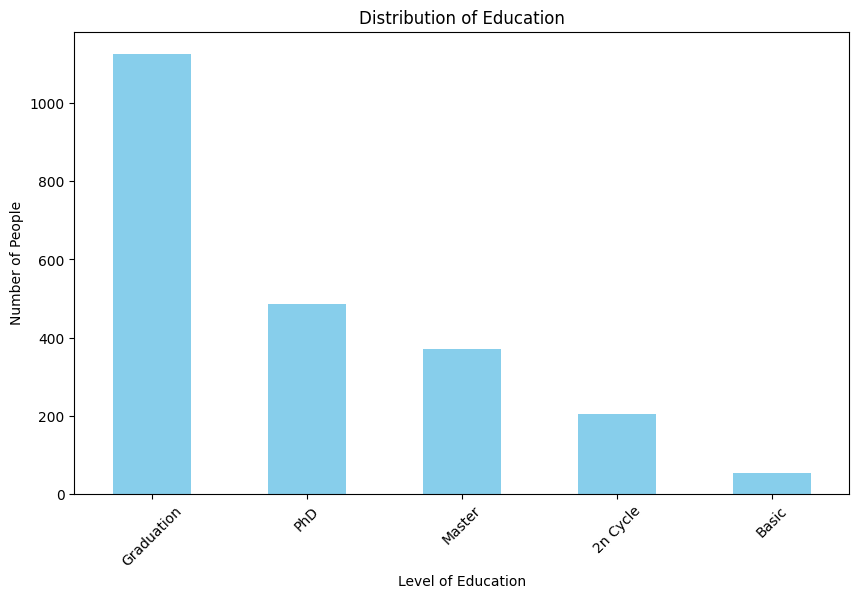

In [63]:
educationCount = df['Education'].value_counts()

plt.figure(figsize=(10, 6))
educationCount.plot(kind='bar', color='skyblue')
plt.title('Distribution of Education')
plt.xlabel('Level of Education')
plt.ylabel('Number of People')
plt.xticks(rotation=45) 
plt.show()


In this part of the analysis, the customers are categorized based on their income levels, to get insights on the economic demographics of the custome database.

The incomes were divided into several bins, these ranges helping to identify how many customers fell into each of these groups.


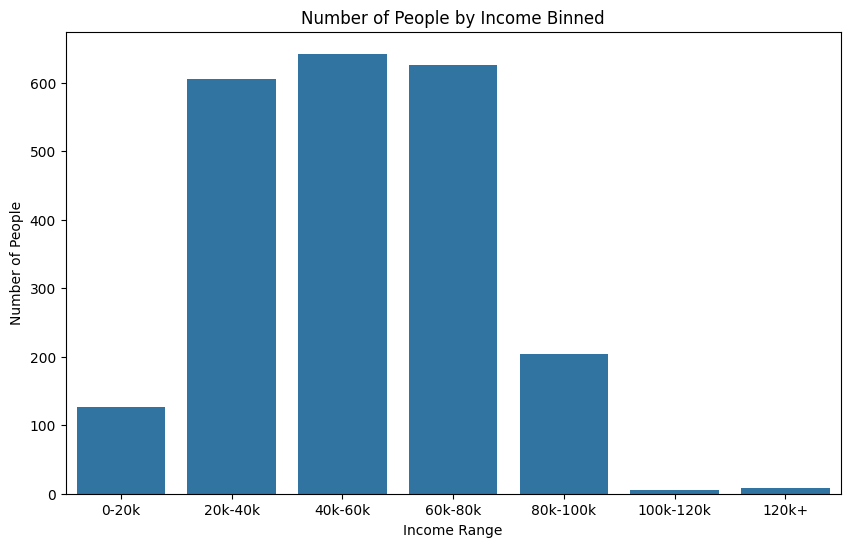

In [64]:
bins = [0, 20000, 40000, 60000, 80000, 100000, 120000, np.inf] 
labels = ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k', '120k+']
df['IncomeRange'] = pd.cut(df['Income'], bins=bins, labels=labels, right=False)
incomeDistribution = df['IncomeRange'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
sns.barplot(x=incomeDistribution.index, y=incomeDistribution.values)
plt.title('Number of People by Income Binned')
plt.xlabel('Income Range')
plt.ylabel('Number of People')
plt.xticks(rotation=0)
plt.show()

Here it is used the Elbow method to determine the nr of clusters we will need to use in the upcoming analysis. The Elbow method is a graphical methos for finding the optimal K values in a k-means clustering algorithm. The optimal K value is the point at which the graph forms an elbow.

Exaplanation of the output:
* The rate of decrease from 1 to 3 clusters is significant, suggesting that 3 clusters will fit the model. The graph suggests that the clusters beyond 3 do not capture as much additional data or really important data relatively to the increase in the number of clusters.

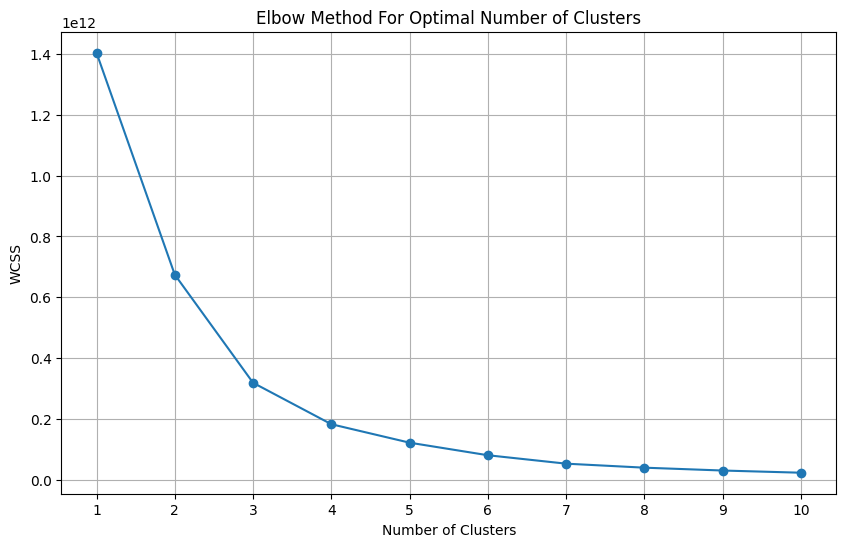

In [65]:
df.dropna(subset=['Income'], inplace=True)
data = df[['Income']].values.reshape(-1, 1)

# Calculate WCSS for different number of clusters
wcss = []
for i in range(1, 11):  # Test 1 to 10 clusters, adjust range as needed
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In this analysis, the customers are categorized by their incomes, BUT using another method: K-means clustering. The nr of clusters was chosen after using the elbow method for determining the optimal number of clusters (check previous cell).

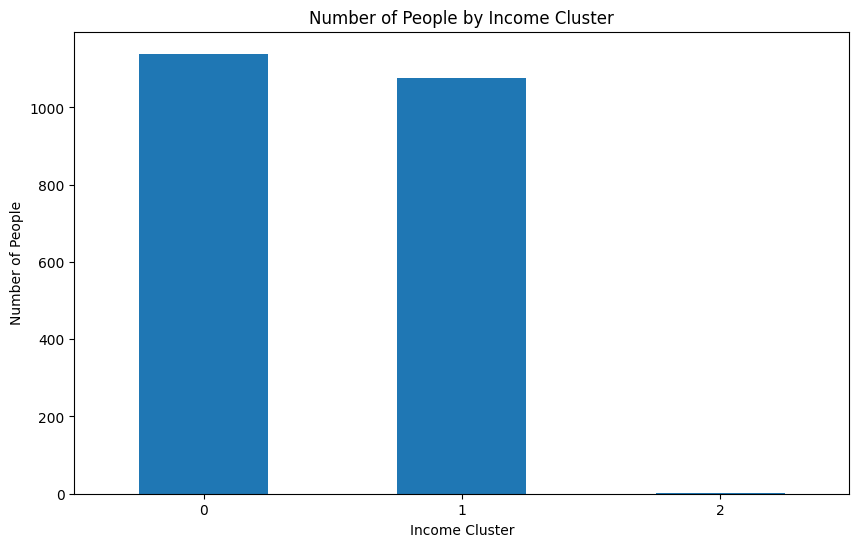

In [66]:
df.dropna(subset=['Income'], inplace=True)
data = df[['Income']].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data)
df['IncomeCluster'] = kmeans.labels_

means = df.groupby('IncomeCluster')['Income'].mean().sort_values()
order = {old: new for new, old in enumerate(means.index)}
df['IncomeCluster'] = df['IncomeCluster'].map(order)

income_cluster_count = df['IncomeCluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
income_cluster_count.plot(kind='bar')
plt.title('Number of People by Income Cluster')
plt.xlabel('Income Cluster')
plt.ylabel('Number of People')
plt.xticks(rotation=0)
plt.show()

In this section, the dataset is getting prepared for machine learning modeling and evaluate the optimal number of clusters for K-means clustering using the Elbow method.

Steps:
1. We derive the age of the customers from their year of birth.
2. In order to not to lose data, the numeric columns in the dataset are identified and filled with the mean of each column the missing values.
3. Since the education column is a string column, it is encoded it into numeric labels, using LabelEncoder (K-means clustering is sensitive to the scales of the data points).
4. The features are scaled, in order to ensure that all of them are treated equally.

Now, the Elbow method is a pplied for a range of clusters (from 1 to 10).

Explanation of the output: 
* Here we observe that the WCSS value changes at value 2, resulting that 2 clusters will give us enough insights for our database.

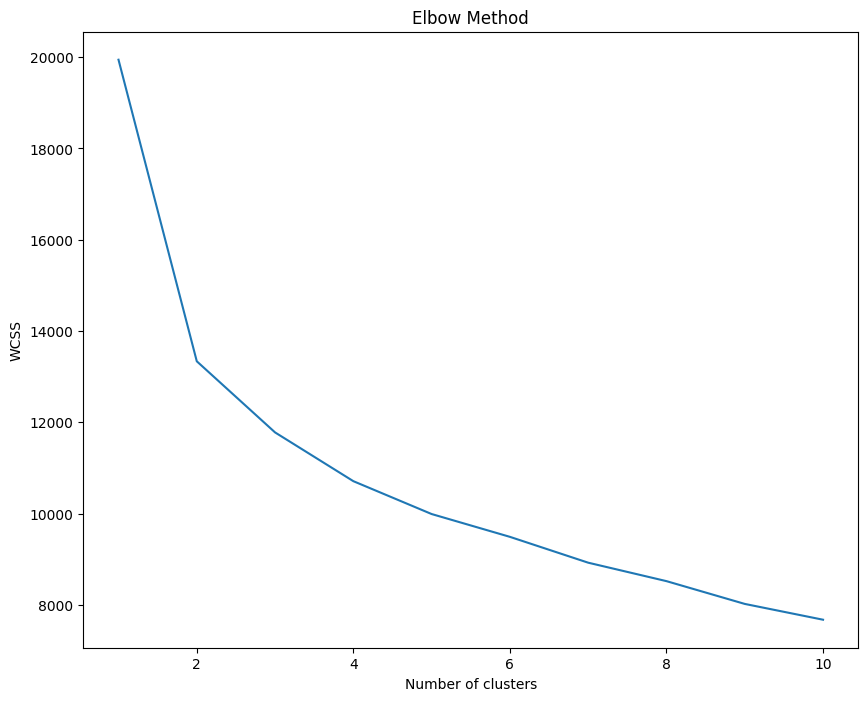

In [67]:
df['Age'] = 2024 - df['Year_Birth']

numericColumns = df.select_dtypes(include=[np.number]).columns
df[numericColumns] = df[numericColumns].fillna(df[numericColumns].mean())

labelEncoder = LabelEncoder()
df['Education'] = labelEncoder.fit_transform(df['Education'])

features = df[['Income', 'Age', 'Education', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

scaler = StandardScaler()
featuresScaled = scaler.fit_transform(features)

wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(featuresScaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In this analysis, the K-means clustering is used to segment the customer database based on various features, such as income, age, education and spending habits. This segmentation helps in understanding different customer profiles and directs the direction of tailoring marketing strategies accordingly.

Explanation of the output: 
* The customers are grouped in terms of their normalized income and age - features used for clustering.
* There are observed several patterns: one cluster predominantly contains younger or loewr-income customers, while another might consist of older or higher-income customers.
* There are also observed some outliers, that are far from others withing the same color group (cluster). They still share similar characteristics with their group, but they differ more than the average member of the group they are coming from.

Cluster 0:
Average Income: 41145.317438692095
Average Age: 54.485013623978205
Education Mode: 2
Average Spend on Wines: 150.5449591280654


Cluster 1:
Average Income: 74035.53877005348
Average Age: 56.5427807486631
Education Mode: 2
Average Spend on Wines: 608.3997326203208




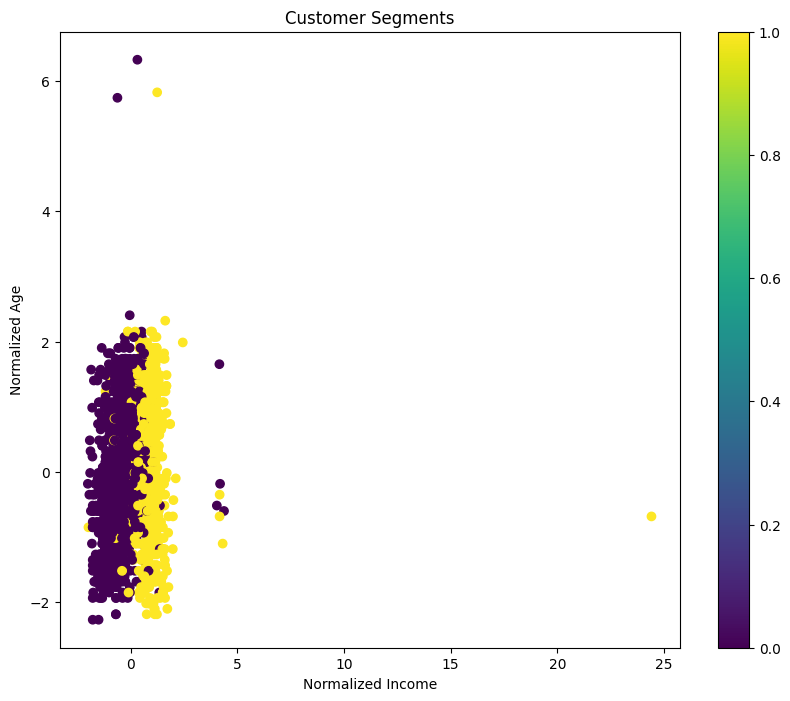

In [68]:
kmeans = KMeans(n_clusters=2, random_state=0) 
clusters = kmeans.fit_predict(featuresScaled)
df['Cluster'] = clusters  

for i in range(2): 
    cluster_data = df[df['Cluster'] == i]
    print(f"Cluster {i}:")
    print(f"Average Income: {cluster_data['Income'].mean()}")
    print(f"Average Age: {cluster_data['Age'].mean()}")
    print(f"Education Mode: {cluster_data['Education'].mode()[0]}")
    print(f"Average Spend on Wines: {cluster_data['MntWines'].mean()}")
    print("\n")

plt.figure(figsize=(10, 8))
plt.scatter(featuresScaled[:, 0], featuresScaled[:, 1], c=clusters, cmap='viridis', label='Clusters')
plt.xlabel('Normalized Income')
plt.ylabel('Normalized Age')
plt.title('Customer Segments')
plt.colorbar()
plt.show()

In this section was analyzed how the number of purchases may depend on the level of education. 
In order to enhance understandability, the numercial values were mapped to the corresponding string values they are representing.

Explanation of the output:
* Customers with a 'Basic' and 'Second cycle' level of education appear to be the most engaged in the web purchases. 
* Customers with a 'PhD Degree', show significantly fewer purchases compared to other groups, showcasing that these customers have specific preferences or constraints that aren't as well taken into account by the current campaigns.
* Customer with 'Graduation' and 'Master's Degree' fall in the middle range in terms of web purchasing activity, suggesting a moderate level of engagement or a balanced distribution of preferences and access among these educational groups.

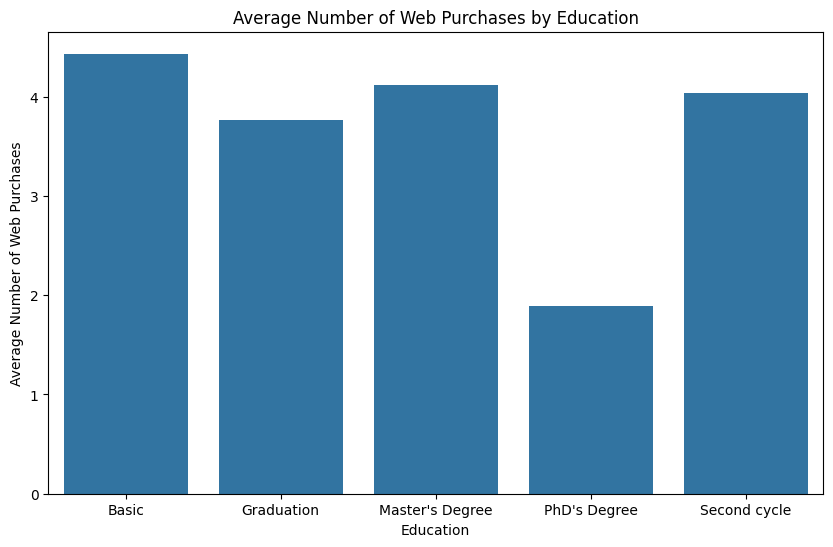

In [69]:
education_labels = {
    0: 'Graduation',
    1: "PhD's Degree",  
    2: "Master's Degree",  
    3: 'Second cycle',
    4: 'Basic'
}
df['Education'] = df['Education'].map(education_labels)

averagePurchases = df.groupby('Education')['NumWebPurchases'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y='NumWebPurchases', data=averagePurchases)
plt.title('Average Number of Web Purchases by Education')
plt.xlabel('Education')
plt.ylabel('Average Number of Web Purchases')
plt.xticks(rotation=0)
plt.show()

This section of the analysis aims to understand how the presence of children affect spending behavior across various product categories. 

Steps: 
1. The customers are cetegorized into one of four types based on the presence of children
    * No children
    * Only Teenagers
    * Only Young Children
    * Young Children and Teenagers
2. The average spending is computed in several product categories
3. The data is plotted and the conclusions can be made.

(Here and further, customers = families)

Explanation of te output:
* Families with 'No Children' and 'Only teenagers' spend significantle more on wines compared to the other 2 groups. 
* In families with 'Only Young Children' and 'Young children and teenagers' there is observed significantly low spending on wined and gold products. This my reflect budgeting priorities where essentials take precedence over luxury purchases.
* Spending on meats and fruits appears relatively moderate across all family types, suggesting these are considered essential across the board. However, families with 'Only Young Children' show slightly higher spending on these, possibly due to the dietary needs of the growing up organism.
* Fish and Sweet Products show the least variation. However, the families with 'No Children' are spending more on fish products, potentially because their preferences and purchases are not influenced by children's taste.



                                MntWines  MntFruits  MntMeatProducts  \
Family_Type                                                            
No Children                   488.072670  52.274882       370.865719   
Only Teenagers                417.340000  26.863077       139.016923   
Only Young Children            81.692607  10.031128        48.984436   
Young Children and Teenagers  128.572792   6.439141        47.174224   

                              MntFishProducts  MntSweetProducts  MntGoldProds  
Family_Type                                                                    
No Children                         76.619273         53.180095     64.235387  
Only Teenagers                      36.453846         28.330769     55.964615  
Only Young Children                 14.566148          9.375486     21.564202  
Young Children and Teenagers         8.885442          7.157518     22.207637  


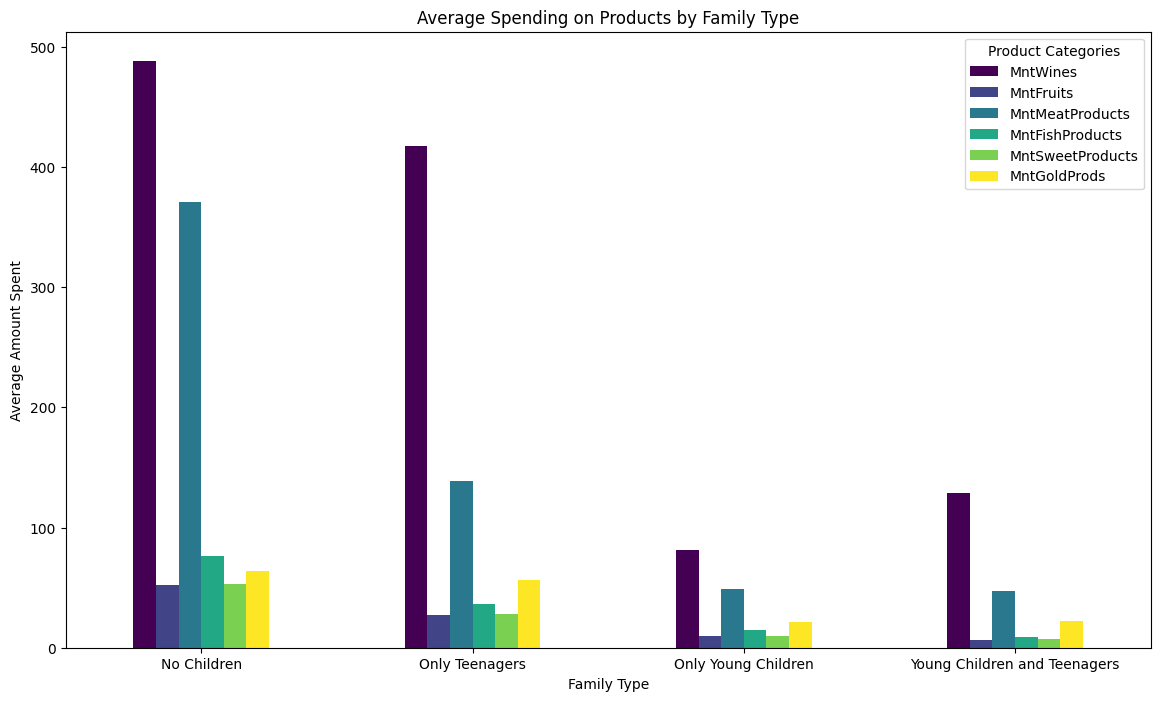

In [70]:
def familyType(row):
    if row['Kidhome'] > 0 and row['Teenhome'] > 0:
        return 'Young Children and Teenagers'
    elif row['Kidhome'] > 0:
        return 'Only Young Children'
    elif row['Teenhome'] > 0:
        return 'Only Teenagers'
    else:
        return 'No Children'

df['Family_Type'] = df.apply(familyType, axis = 1)
familySpending = df.groupby('Family_Type')[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].mean()

print(familySpending)

familySpending.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Average Spending on Products by Family Type')
plt.xlabel('Family Type')
plt.ylabel('Average Amount Spent')
plt.xticks(rotation=0)
plt.legend(title='Product Categories')
plt.show()

This section aims to provide insights on how family type affects the number of web store visits and purchases.

Explanation of the output:
- Customers with 'Only Young Children' and 'Young Children and Teenagers' tend to have significantly more recent visits to web shops than the number of purchases. This may occur due to budget allocation towards raising children.
- Customers with 'No children' and 'Only Teenagers' are more inclined to shop online. This may indicate that these groups do not have to spend money on children and can fully indulge in their own desires (in the case of 'No children'), OR, in the case of the customers with 'Only Teenagers', the teenagers may have part-time jobs and are becoming more responsible, able to afford their needs without relying on their parents' money.

                              NumWebVisitsMonth  NumWebPurchases
Family_Type                                                     
No Children                            3.492891         4.406003
Only Teenagers                         5.204615         5.541538
Only Young Children                    6.838521         2.723735
Young Children and Teenagers           6.391408         3.011933


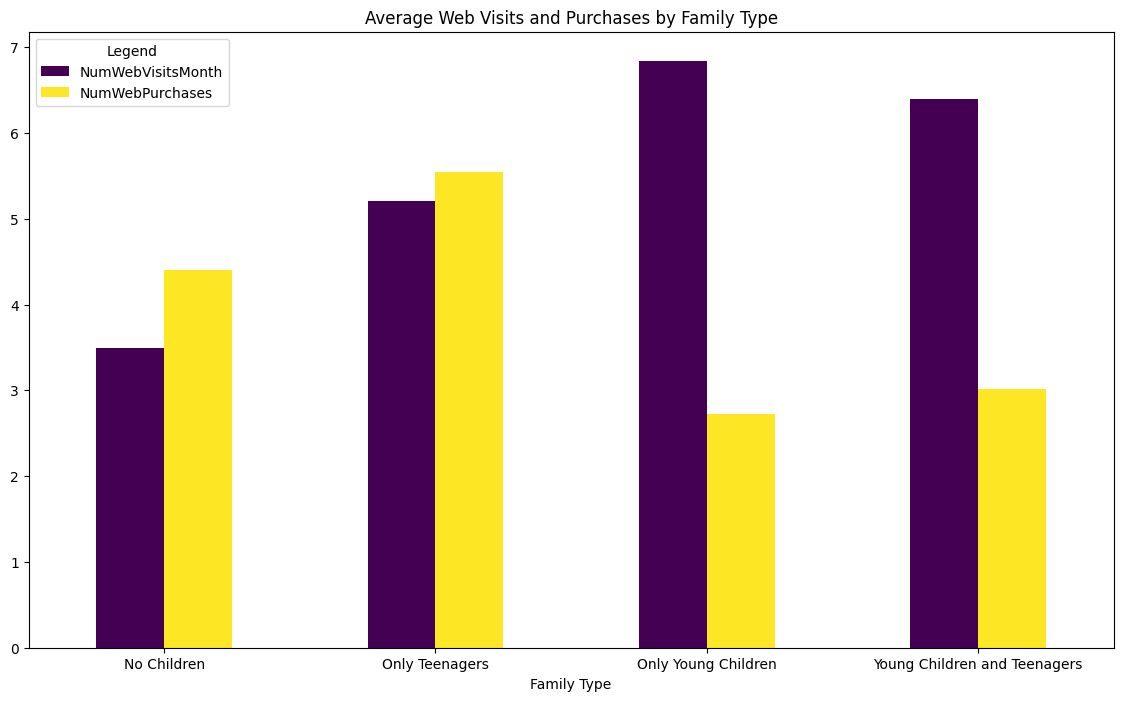

In [71]:
familySpending = df.groupby('Family_Type')[['NumWebVisitsMonth', 'NumWebPurchases']].mean()

print(familySpending)

familySpending.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Average Web Visits and Purchases by Family Type')
plt.xlabel('Family Type')
plt.xticks(rotation=0)
plt.legend(title='Legend')
plt.show()


In this section is analyzed the average income by Family Type. 

Explanation of the output:
* It is evident that the customers with 'No children' and 'Only Teenagers' have the highest income. This may imply that these individuals have accumulated enough experience and consequently earn better salaries. Additionally, the substantial income of those with 'No children' indicates that these customers likely have grown-up children who no longer live at home, suggesting their older age.
* Conversely, customers with 'Only Young Children' and 'Young Children' have relatively lower incomes compared to the other two groups, indicating their younger age.



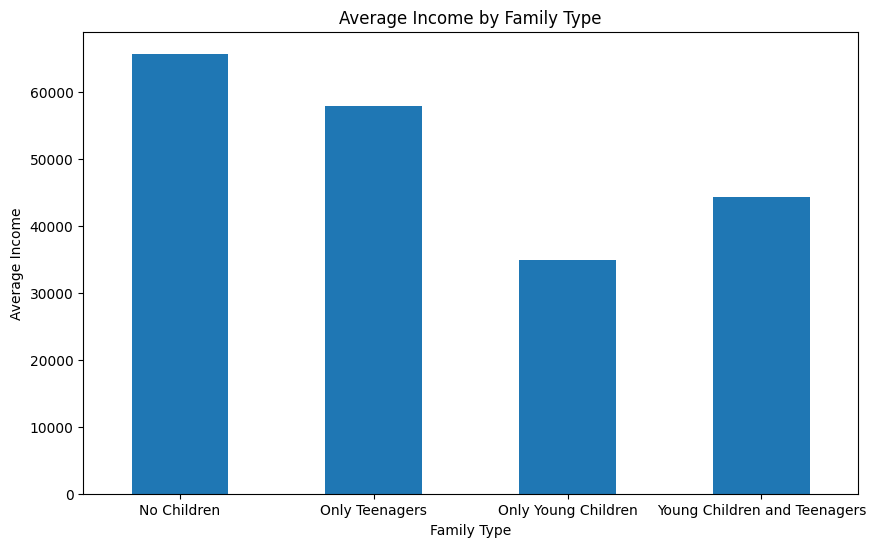

In [72]:
df_withChildren = df[(df['Kidhome'] > 0) | (df['Teenhome'] > 0) | ((df['Kidhome'] == 0) & (df['Teenhome'] == 0))]

familySpending = df.groupby('Family_Type')[['NumWebVisitsMonth', 'NumWebPurchases']].mean()

familyIncome = df_withChildren.groupby('Family_Type')['Income'].mean()

plt.figure(figsize=(10, 6))
familyIncome.plot(kind='bar')
plt.title('Average Income by Family Type')
plt.xlabel('Family Type')
plt.ylabel('Average Income')
plt.xticks(rotation=0)
plt.show()

In this section, the Campaign Acceptance Rate by Marital Status is analyzed.

Explanation of the output:
* Campaigns 1 and 5 were well-targeted for individuals who found the question about marital status absurd.
* Campaign 3 was effectively tailored for people who are alone.
* Married and Together: these groups exhibit moderate acceptance rates across several campaigns, indicating that these campaigns are somewhat effectively reaching and resonating with individuals in stable relationships.
* Single and Divorced: these categories demonstrate lower acceptance rates overall, suggesting that the campaigns might not be as effective or appealing to these individuals.
* The acceptance rates for the 'Widow' category are relatively low across all campaigns, possibly indicating that none of the campaigns effectively addressed this demographic's interests or needs.

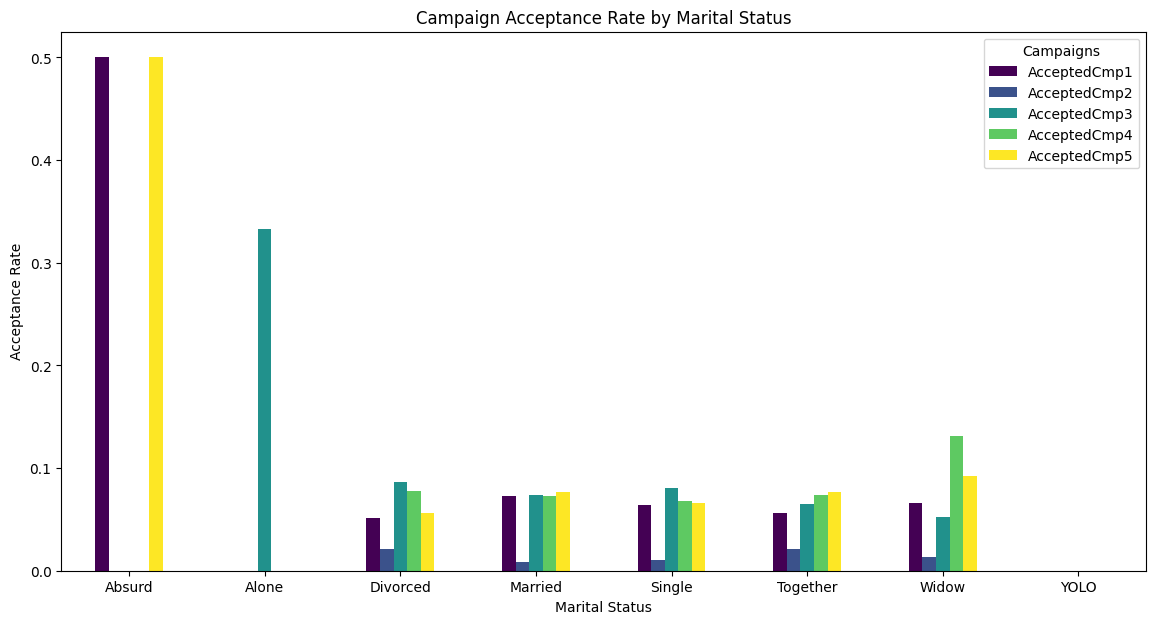

In [73]:
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

campaignSuccessMaritalStatus = df.groupby('Marital_Status')[campaigns].mean()

campaignSuccessMaritalStatus.plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title('Campaign Acceptance Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Acceptance Rate')
plt.legend(title='Campaigns')
plt.xticks(rotation=0)
plt.show()


Now it is analyzed the acceptance rate by family type in percentages.

Explanation of the output:
* We can observe high acceptance rate of the 5th and 1st campaign for the customers with 'No children'. 
* The 4th campaign had significant succes for the people with 'No children' and with 'Only teenagers'.
* The 3rd campaign was well tailored for the customers with 'Only Young Children'.
* The 2nd campaign wasn't well designed, so the acceptance rate is small.

Note: it is observable that the customers with 'No children' are more exposed to accet a campaign. This can suggest that they have more free time which they can spend on fulfilling their desires.

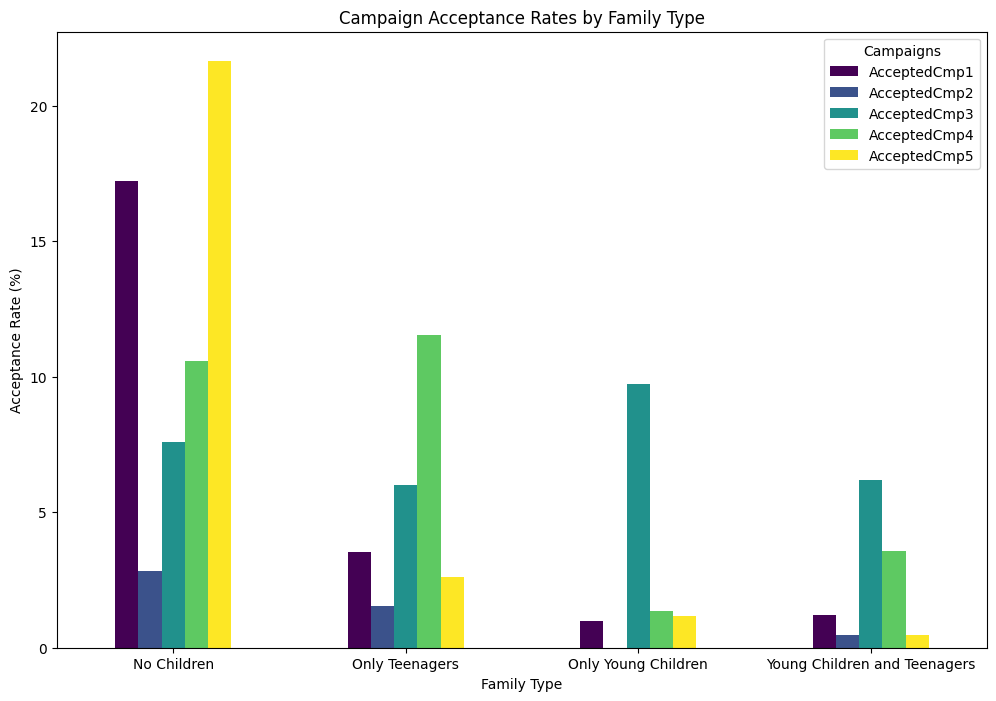

In [74]:

campaignAcceptance = df.groupby('Family_Type')[campaigns].mean() * 100 

campaignAcceptance.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Campaign Acceptance Rates by Family Type')
plt.xlabel('Family Type')
plt.ylabel('Acceptance Rate (%)')
plt.xticks(rotation=0)  
plt.legend(title='Campaigns')
plt.show()


This model is aimed to predict customer responses to the marketing campaign 'AcceptedCmp5', using logistic regression.

This prediction helps in understanding which customers are likely to be responsive to the campaign, based on their income, household composition, recent purchase(s), and responses to previous campaigns. 

Explanation of the output: 
* The accuracy is 0.9437 (94.37%), indicating that the model correctly predicts whether the customers will accept the campaign. The value in 0.9437 is high accurate, suggesting that the model performs well overall.
* The ROC AUC value is 0.7795. It is an avergae value, suggesting theat the model can distinguish between those who will accept the campaign, and whose who will not. 
* Predicted and Actual values: the first arrayx - predicted values, second - actual values:
                   <p> [0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
                   <p> [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1] 

    This small sample represents that the model is almost correctly. 3 entries out of 20 are eronous, this being a good overall result.
* Predicted probabilities: these probabilities give insights into the confidence of the model's prediction. For example, the high probabilities (0.9228 and 0.5293 for the fifth and tenth entries) align with the correct predictions where the actual values are 1. Lower probabilities (like 0.0005 for the third entry) correctly predict non-acceptance.


In [75]:
X = df[['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntMeatProducts', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4']].copy()
y = df['AcceptedCmp5']  


X.fillna(X.mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

print("Predicted values:\n", y_pred[:20])
print("Actual values:\n", y_test[:20].values)

y_probs = model.predict_proba(X_test)[:, 1]  
print("\nPredicted probabilities:", y_probs[:20])



Accuracy: 0.9436936936936937
ROC AUC: 0.779509725552891
Predicted values:
 [0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Actual values:
 [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1]

Predicted probabilities: [6.31913509e-03 1.92672530e-03 4.67092147e-04 5.47161597e-01
 1.55520692e-03 9.22798467e-01 1.39129439e-01 9.62692218e-03
 7.40727730e-04 5.29297639e-01 1.74381298e-03 1.92568355e-03
 1.80574158e-03 1.14194048e-02 4.13570326e-04 6.80315939e-02
 2.56405126e-03 1.01950569e-01 1.30782591e-03 4.96185695e-01]


Now, it is analysed the feature importance in the logistic regression model, giving insights into which variables most strongly influence the probability of the acceptance of marketing campaign 5. 

Interpreting the coefficients: 
* Positive coefficients: indicate that as the feature increase, the event is more likely to occur.
* Negative coefficients: as the feature decreases, the event is less likely to occur.

Explanation of the output:
* MntWines: the most significant positive coefficient, sugesting that the amount spent on wines is a strong predictor of accepting the campaign.
* Teenhome, Kidhome: the only features with considerable negative coefficients, suggesting that children presence of any age decrease the likelihood of accepting the campaign.
* Income, MntMeatProducts: have a small positive coefficient, having a small impact on the overall likelihood (if compared to MntWines)
* AcceptedCmp1, -2, -3, -4: these features have a mixed impact, but overall suggesting that th ecustomers that accepted campaigns from 1 to 4, are slightly likely to accepted campaign 5.
* Recency: has a small negative impact, suggesting that more recent interactions with the company are very slightly negatively associated with campaign acceptance.

Conclusion: 
* Focus on Wine Lovers
* Tailor campaign offers that might appeal more to people without any children.
* Analyze why the acceptance of the first 4 campaign might deter accptance of the currently analyzed campign.

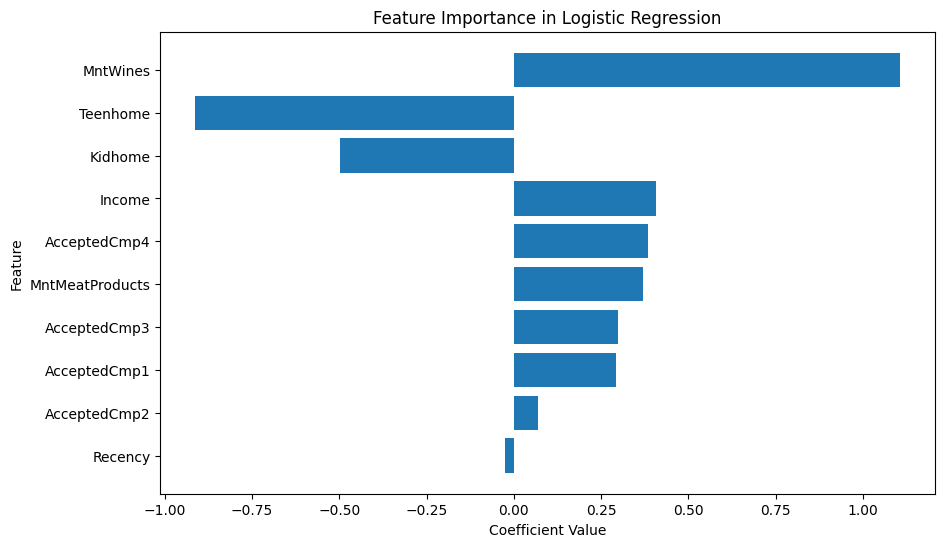

In [76]:
coefficients = model.coef_[0]
featureImportance = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
featureImportance['abs'] = featureImportance['Coefficient'].abs()
featureImportance = featureImportance.sort_values(by='abs', ascending=False).drop('abs', axis=1)
plt.figure(figsize=(10, 6))
plt.barh(featureImportance['Feature'], featureImportance['Coefficient'])
plt.ylabel('Feature')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis() 
plt.show()

In conclusion, the comprehensive analysis if the customer database based on different demographic and behavioral dimensions has yielded critical insights into effective marketing strategies.

The observed prevalence of certain birth years suggests targeted campaigns towards these groups could increase engagement, while the marital status data indicates that 'Married' or people who are 'Together' are prime targets for future intiatives.

Educational achievments and economic profiles further refine the target audience, highlighting the importance of addressing the needs of people with higher level of education and financially diverse customer segments.

The application of the Elbow method and subsequent K-means clustering revealed optimal segmentation strategies, emphasizing the utility of age and income as primary clustering features. This segmentation allows more personalized marketing approaches, taking into account different behavioral patterns and spending capabilities across different demographic groups.

Additionally, the analysis of the family type and purchasing behaviors underscores the nuanced impact of household composition on consumption patterns. Families with children (of any age) have different spending priorities compared to those families without children.

Finally, the logistice regression model has provided predictive lesn through which is possible to view campaigns effectiveness, identifying the significant role of wine expenditures in predicting campaign acceptance. Moreover, it indicates that presence of children may negatively affect the campaign success.

To sum up, these insights not only facilitate a deeper understanding of the customer base but also guide the direction of the marketing campaigns to better allign with the preferences of different customer segments, in order to enhance customer engagement, improve response rates, and ultimately drive sales more effectively.